# Pattern spectra - granulometry based on connected filters

This notebook contains a demonstration showing how to compute efficiently a pattern spectra of an image, i.e. a granulometric curve based on a connected fitler.

A pattern spectra is defined by:

1. A parametric connected filter $\sigma_k$ such that for any image $I$ and for any $k_1<k_2 \in \mathbb{R}$, we have $\sigma_{k_1}(I) \geq \sigma_{k_2}(I)$ and $\sigma_{k_1}(\sigma_{k_2}(I))=\sigma_{k_2}(I)$
2. A measure $m$ that associates a real value $m(I)$ to any image $I$.

The pattern spectra of the image $I$ for the parametric connected filter $\sigma$ and the measure $m$ is then defined as the function $P_I^{\sigma,m}$ defined by   $P_I^{s,m}(k) = m(\sigma_k(I))$. Note that one may also consider the derivative of this function.

We will show how to compute naively and efficiently two pattern spectra:

1. The first one mesaures the evolution of the volume of an image with respect to an area filter.
2. The second one measures the evolution of the number of maxima with respect to a dynamics filter.

One can refer to the following article for a complete description of pattern spectra.

    Urbach, E. R., Roerdink, J. B., & Wilkinson, M. H. (2007). Connected shape-size pattern spectra for rotation and 
    scale-invariant classification of gray-scale images. IEEE Transactions on Pattern Analysis and Machine Intelligence, 
    29(2), 272-285.
    

In [1]:
%%capture
!pip install higra

In [2]:
#usual import, setup, and magic
import numpy as np
import imageio
%matplotlib inline
import matplotlib.pyplot as plt
import higra as hg

try:
    from utils import * # imshow, locate_resource, get_sed_model_file
except: # we are probably running from the cloud, try to fetch utils functions from URL
    import urllib.request as request; exec(request.urlopen('https://github.com/higra/Higra-Notebooks/raw/master/utils.py').read(), globals())

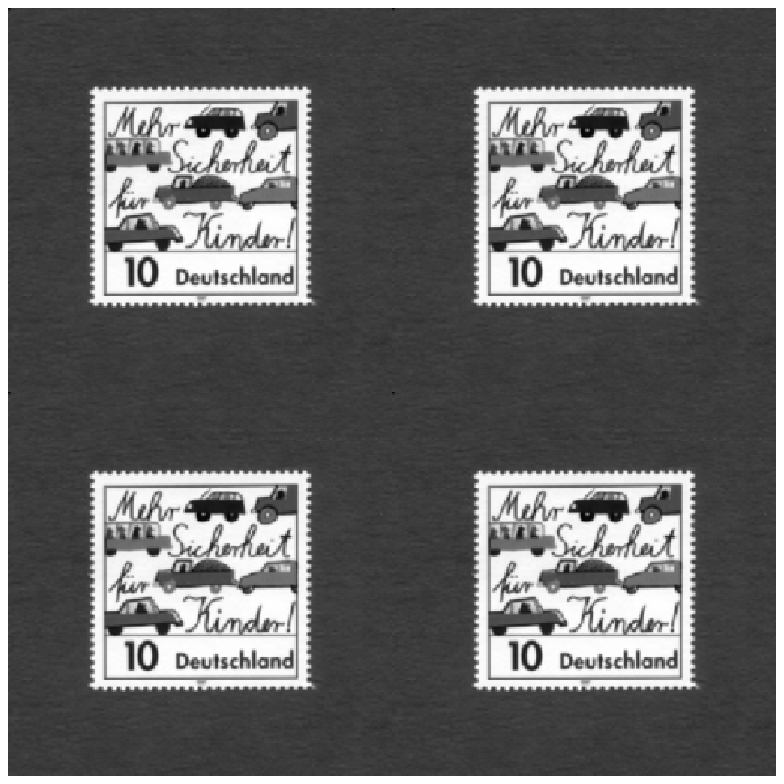

In [3]:
# test image
image = imageio.imread(locate_resource("stample4.png"))

imshow(image, cmap="gray");

## Area - Volume pattern spectra

In this first example, the pattern spectra function is defined by:

1. the connected area opening of size $k$ as the parametric filter;
2. the volume of the image (sum of pixel values) as the measure.


### Naive implementation

A naive implementation to compute this connected filter is simply to explicitely computed each filter of the image and to measure their volume:

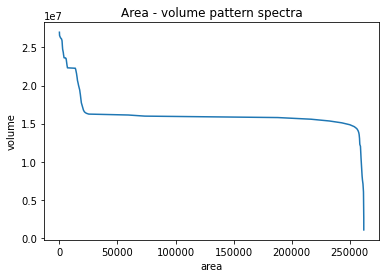

In [4]:
def pattern_spectra_area_volume_trivial(image):
    # create a 4 adjacency graph
    graph = hg.get_4_adjacency_implicit_graph(image.shape[:2])
    # compute the max-tree of the image
    tree, altitudes = hg.component_tree_max_tree(graph, image)
    # compute the area of each node of the tree
    area = hg.attribute_area(tree)
    # find all unique area values: these are the interesting area filter thresholds
    area_uniques = np.unique(area)

    granulometry = np.zeros_like(area_uniques)
    
    for i in range(len(area_uniques)): # for all thresholds
        # create a filtered image by removing all the nodes whose size is bellow the current threshold
        filtered_image = hg.reconstruct_leaf_data(tree, altitudes, area <= area_uniques[i])
        # measure the volume of the filtered image
        granulometry[i] = filtered_image.sum()
        
    return area_uniques, granulometry

x, y = pattern_spectra_area_volume_trivial(image)

plt.plot(x, y);
plt.xlabel("area")
plt.ylabel("volume")
plt.title("Area - volume pattern spectra");

## Efficient implementation

The previous naive implementation will quickly get slower as the number of pixels, the number of nodes and the number of different area values increase. We can devise a more efficient implementation by avoiding to create the filtered image at every threshold and directly measure the evolution of the volume of this image on the implicitely filtered tree.

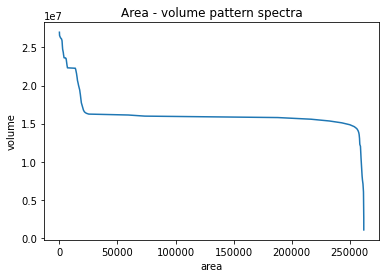

In [5]:
def pattern_spectra_area_volume_optimized(image):
    # create a 4 adjacency graph
    graph = hg.get_4_adjacency_implicit_graph(image.shape[:2])
    # compute the max-tree of the image
    tree, altitudes = hg.component_tree_max_tree(graph, image)
    # compute the area of each node of the tree
    area = hg.attribute_area(tree)
    
    # compute the volume associated to each node: each time we remove a node, the volume of the corresponding image
    # is decreased by this value
    vol_nodes = area * abs(altitudes - altitudes[tree.parents()])
    
    # volume of the original image
    vol_total = np.sum(image)

    # find all unique area values: these are the interesting area filter thresholds
    unique_areas, area_map = np.unique(area, return_inverse=True)
    
    # accumulate the node volumes of every nodes which have the same area
    vol_areas = hg.accumulate_at(area_map, vol_nodes, hg.Accumulators.sum)

    # at each threshold value, the volume decreases by the volume of all nodes with an area bellow this thresold
    y = vol_total - np.cumsum(vol_areas)  

    return unique_areas, y

x2, y2 = pattern_spectra_area_volume_optimized(image)

plt.plot(x2, y2);
plt.xlabel("area")
plt.ylabel("volume")
plt.title("Area - volume pattern spectra");

In [6]:
# sanity check
assert np.allclose(x,x2)
assert np.allclose(y,y2)

In [7]:
#%%timeit
#pattern_spectra_area_volume_trivial(image)

940 ms ± 32.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
#%%timeit
#pattern_spectra_area_volume_optimized(image)

82.8 ms ± 2.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Dynamics - Number of maxima pattern spectra

In this first example, the pattern spectra function is defined by:

1. the connected dynamic opening as the parametric filter;
2. the number of maxima of the image as the measure.

### Naive implementation

A naive implementation to compute this connected filter is to start from the max-tree of the image and iteratively removes its nodes whose dynamics is below the current threshold to count the number of leaves in the filtered tree:

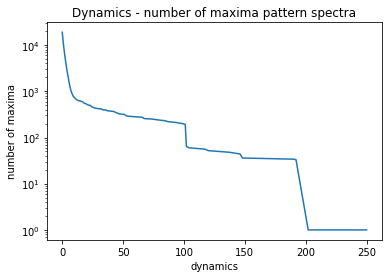

In [9]:
def pattern_spectra_dynamics_num_extrema_trivial(img):
    # create a 4 adjacency graph
    graph = hg.get_4_adjacency_implicit_graph(image.shape[:2])
    # compute the max-tree of the image
    tree, altitudes = hg.component_tree_max_tree(graph, img)
    # compute the dynamics of each node of the tree
    dynamics = hg.attribute_dynamics(tree, altitudes)
    # find all unique dynamics values: these are the interesting filter thresholds
    dynamics_uniques = np.unique(dynamics)
    
    granul = np.zeros_like(dynamics_uniques)
    
    for i in range(len(dynamics_uniques)):
        # remove all the nodes of the tree whose dynamics is lower than the current threshold
        filtered_tree, nodes_map = hg.simplify_tree(tree, dynamics <= dynamics_uniques[i], process_leaves=True)
        granul[i] = filtered_tree.num_leaves()
        
    return dynamics_uniques, granul

x, y = pattern_spectra_dynamics_num_extrema_trivial(image)
plt.plot(x, y);
plt.yscale("log")
plt.xlabel("dynamics")
plt.ylabel("number of maxima")
plt.title("Dynamics - number of maxima pattern spectra");

## Efficient implementation

The previous naive implementation will quickly get slower as the number of pixels, the number of nodes and the number of different dynamics values increase. We can devise a more efficient implementation by avoiding to explicity filter the tree at every threshold and directly measure the evolution of the number of leaves in the implicitely filtered tree.

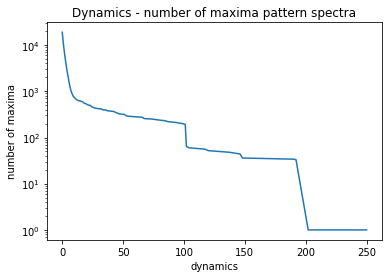

In [10]:
def pattern_spectra_dynamics_num_extrema_optimized(image):
    # create a 4 adjacency graph
    graph = hg.get_4_adjacency_implicit_graph(image.shape[:2])
    # compute the max-tree of the image
    tree, altitudes = hg.component_tree_max_tree(graph, image)
    # compute the dynamics of each node of the tree
    dynamics = hg.attribute_dynamics(tree, altitudes)

    # the number of leaves will decrease iif the current node is not the 
    # the child of largest dynamics (otherwise, when it is removed, its parent 
    # does not have any child left and it becomes a leaf node itself)
    max_child = hg.accumulate_parallel(tree, dynamics, hg.Accumulators.argmax)
    var_nodes = hg.attribute_child_number(tree) != max_child[tree.parents()] 
    var_nodes[-1] = 0 # correction for root
    var_nodes = var_nodes.astype(np.float64)

    num_leaves = tree.num_leaves()

    # find all unique dynamics values: these are the interesting filter thresholds
    unique_dynamics, dynamics_map = np.unique(dynamics, return_inverse=True)
    
    # accumulate the node variations of every nodes which have the same dynamics
    var_dynamics = hg.accumulate_at(dynamics_map, var_nodes, hg.Accumulators.sum)
    
    # at each threshold value, the number of maxima decreases by the variation of all nodes 
    # with a dynamics bellow this thresold
    y = num_leaves - np.cumsum(var_dynamics)  

    return unique_dynamics, y

x2, y2 = pattern_spectra_dynamics_num_extrema_optimized(image)
plt.plot(x2, y2);
plt.yscale("log")
plt.xlabel("dynamics")
plt.ylabel("number of maxima")
plt.title("Dynamics - number of maxima pattern spectra");

In [11]:
# sanity check
assert np.allclose(x,x2)
assert np.allclose(y,y2)

In [12]:
#%%timeit
#pattern_spectra_dynamics_num_extrema_trivial(image)

805 ms ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
#%%timeit
#pattern_spectra_dynamics_num_extrema_optimized(image)

126 ms ± 6.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
